In [1]:
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))

In [2]:
import bartz
from stochtree import BARTModel
from bart_playground import *

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import arviz as az
import time

INFO:arviz.preview:arviz_base not installed
INFO:arviz.preview:arviz_stats not installed
INFO:arviz.preview:arviz_plots not installed


In [4]:
from pmlb import fetch_data

X, y = fetch_data('1201_BNG_breastTumor', return_X_y=True)

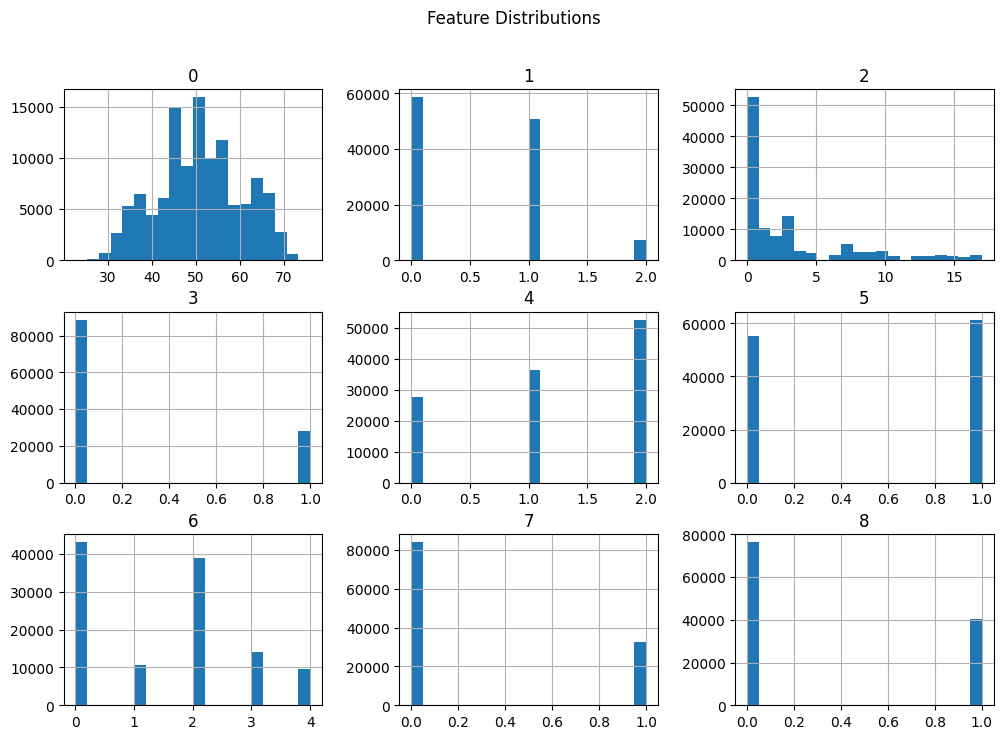

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

X_df = pd.DataFrame(X)
X_df.hist(figsize=(12, 8), bins=20)
plt.suptitle("Feature Distributions")
plt.show()

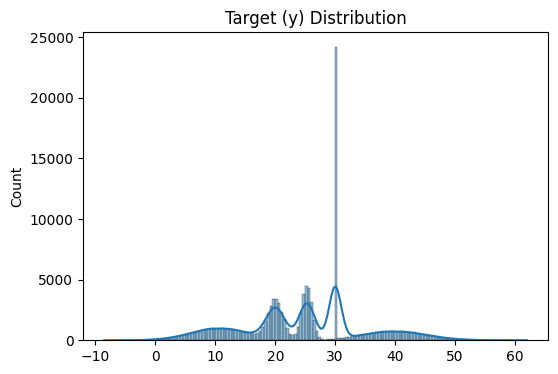

In [6]:
plt.figure(figsize=(6, 4))
sns.histplot(y, kde=True)
plt.title("Target (y) Distribution")
plt.show()

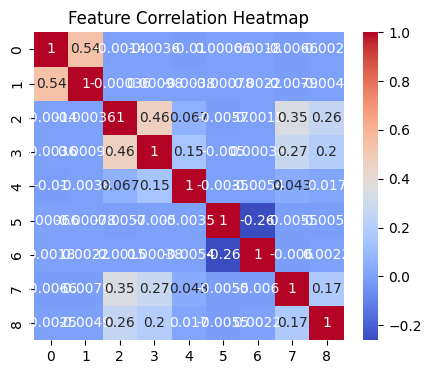

In [7]:
plt.figure(figsize=(5, 4))
corr = X_df.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

In [8]:
import comparison
import pandas as pd

rhat_df = comparison.gelman_rubin_r_compare(X, y, n_runs=5, n_chains=4, ndpost=1000, nskip=1000, n_trees=100, n_jobs=5)
mean_row = pd.DataFrame([rhat_df.mean()], index=["mean"])
std_row = pd.DataFrame([rhat_df.std()], index=["std"])
rhat_df_with_stats = pd.concat([rhat_df, mean_row, std_row])
print("Gelman-Rubin R̂ comparison matrix:")
print(rhat_df_with_stats)

Gelman-Rubin R̂ comparison matrix:
      MultiBART_Rhat_Sigma2  DefaultBART_Rhat_Sigma2  MultiBART_Rhat_RMSE  \
0                  1.002065                 1.010378             1.036596   
1                  1.005220                 1.014438             1.150612   
2                  1.015499                 1.007561             1.233271   
3                  1.003887                 1.005779             1.336582   
4                  1.003367                 1.006053             1.195290   
mean               1.006008                 1.008842             1.190470   
std                0.005425                 0.003622             0.110079   

      DefaultBART_Rhat_RMSE  
0                  1.219893  
1                  1.919236  
2                  1.380593  
3                  1.395213  
4                  1.818181  
mean               1.546623  
std                0.304067  


In [9]:
rhat_df.to_csv("results/real5_BreastTumor_rhat.csv", index=False)

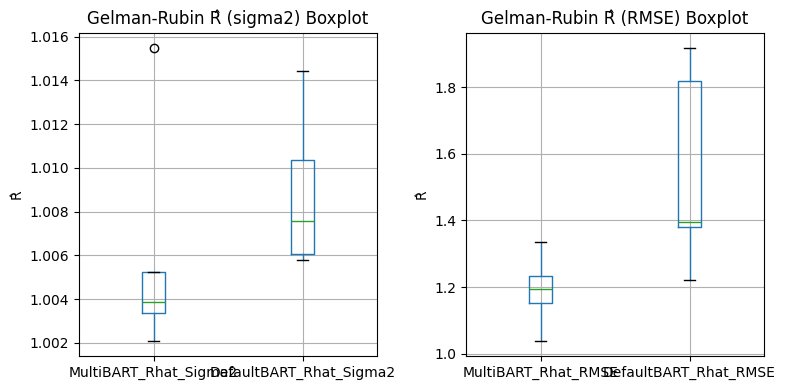

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# sigma2 boxplot
rhat_df[["MultiBART_Rhat_Sigma2", "DefaultBART_Rhat_Sigma2"]].boxplot(ax=axes[0])
axes[0].set_title("Gelman-Rubin R̂ (sigma2) Boxplot")
axes[0].set_ylabel("R̂")

# rmse boxplot
rhat_df[["MultiBART_Rhat_RMSE", "DefaultBART_Rhat_RMSE"]].boxplot(ax=axes[1])
axes[1].set_title("Gelman-Rubin R̂ (RMSE) Boxplot")
axes[1].set_ylabel("R̂")

plt.tight_layout()
plt.show()

test_mse:
      bart_mtmh       bart        btz        sto          rf        xgb
0     87.095652  87.470107  87.289641  87.361580  109.458282  88.657922
1     87.134410  87.559262  87.319037  87.587841  109.713743  88.580468
2     87.513773  87.845659  87.548842  87.784389  110.045747  88.964341
3     87.717046  87.939690  87.834758  87.889804  110.812855  89.112601
4     88.513030  88.837484  88.603959  88.830407  110.663165  90.279935
5     87.501276  87.789314  87.901896  88.060081  110.808684  89.136747
6     87.729692  87.881331  87.892939  88.202668  111.041204  89.535712
7     87.909021  88.106424  88.076816  88.188262  110.612982  89.441630
8     88.246984  88.513149  88.499003  88.738464  111.407565  89.900800
9     87.294557  87.495418  87.466861  87.713474  110.821577  88.721746
mean  87.665544  87.943784  87.843375  88.035697  110.538580  89.233190
std    0.461505   0.442216   0.456904   0.473811    0.609861   0.556879



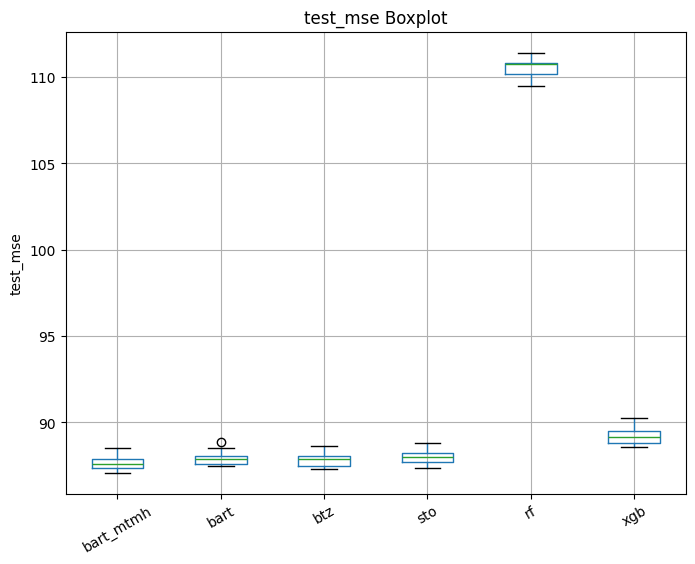

train_mse:
      bart_mtmh       bart        btz        sto         rf        xgb
0     87.081787  87.614465  87.572981  87.835146  15.534903  81.455847
1     87.046172  87.677529  87.598075  87.733016  15.447441  81.404006
2     86.932145  87.511832  87.409541  87.645292  15.395193  81.251570
3     86.929762  87.634694  87.548165  87.567870  15.370045  81.250468
4     86.590277  87.258143  87.244632  87.395613  15.341230  81.338999
5     86.810805  87.470530  87.536499  87.686157  15.404729  81.252545
6     86.763821  87.518652  87.451229  87.656114  15.432257  81.214583
7     86.808296  87.478295  87.415487  87.436507  15.364956  81.153972
8     86.684547  87.271053  87.219002  87.522342  15.369475  81.192552
9     86.926629  87.672521  87.615570  87.829746  15.472823  81.257820
mean  86.857424  87.510771  87.461118  87.630780  15.413305  81.277236
std    0.154981   0.150593   0.140914   0.150734   0.059235   0.094540



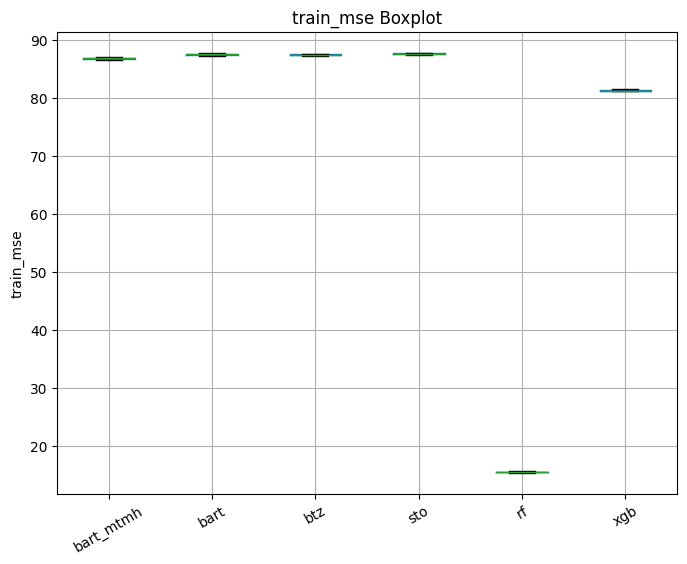

pi_length:
      bart_mtmh       bart        btz         sto
0     36.575549  36.624950  36.718190  344.914686
1     36.578292  36.622317  36.703201  345.644079
2     36.557264  36.589733  36.693480  344.507472
3     36.552175  36.619667  36.667348  346.533779
4     36.475357  36.530662  36.627631  343.553699
5     36.540469  36.599674  36.731457  345.526777
6     36.523345  36.591572  36.678724  347.434686
7     36.526551  36.586575  36.665861  343.015819
8     36.496523  36.548023  36.653861  344.588013
9     36.543458  36.616138  36.715935  346.524893
mean  36.536898  36.592931  36.685569  345.224390
std    0.032693   0.031858   0.032651    1.384142



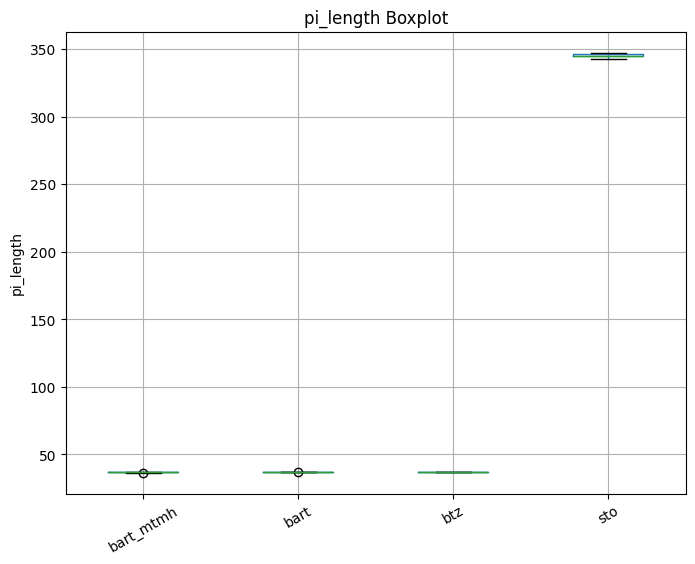

coverage:
      bart_mtmh      bart       btz       sto
0      0.936866  0.937963  0.937449  1.000000
1      0.936557  0.937037  0.936900  0.999966
2      0.936728  0.936420  0.937483  0.999829
3      0.936557  0.938683  0.936866  0.999931
4      0.935288  0.935185  0.936420  0.999931
5      0.937140  0.937826  0.938683  0.999863
6      0.936214  0.936420  0.937209  1.000000
7      0.938374  0.937483  0.938957  1.000000
8      0.936420  0.936557  0.935768  0.999897
9      0.935837  0.935700  0.937037  1.000000
mean   0.936598  0.936927  0.937277  0.999942
std    0.000818  0.001079  0.000958  0.000063



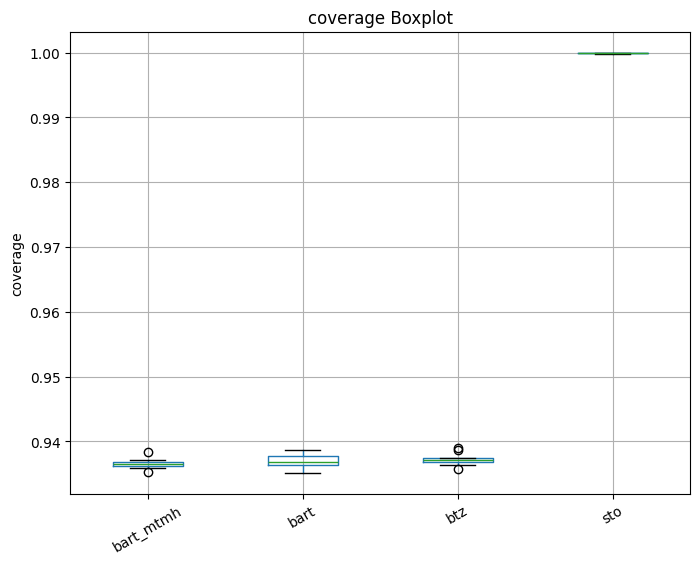

train_time:
        bart_mtmh        bart         btz          sto         rf       xgb
0     3201.679646  373.858093  200.042191  1023.368976  28.538404  0.593054
1     3193.332492  370.916114  198.850383  1025.676311  28.202899  0.598263
2     3185.543042  375.844763  200.548312  1027.436316  27.909702  0.576386
3     3193.436860  366.296999  193.098431  1018.011826  28.179003  0.696668
4     3235.112123  386.772867  190.420839  1022.764623  28.948933  0.554616
5     3553.831981  424.589564  190.982039  1009.766678  28.201878  0.378908
6     3544.037577  421.190150  192.153185  1012.730859  28.256652  0.378871
7     3493.458690  432.586514  190.383248  1021.619592  28.030739  0.363090
8     3474.639738  425.456400  183.611274  1022.672422  27.972636  0.412131
9     3420.079955  403.727494  155.042013  1061.262782  28.260416  0.430755
mean  3349.515210  398.123896  189.513191  1024.531039  28.250126  0.498274
std    160.389573   26.174354   13.192900    14.044001   0.302255  0.118498


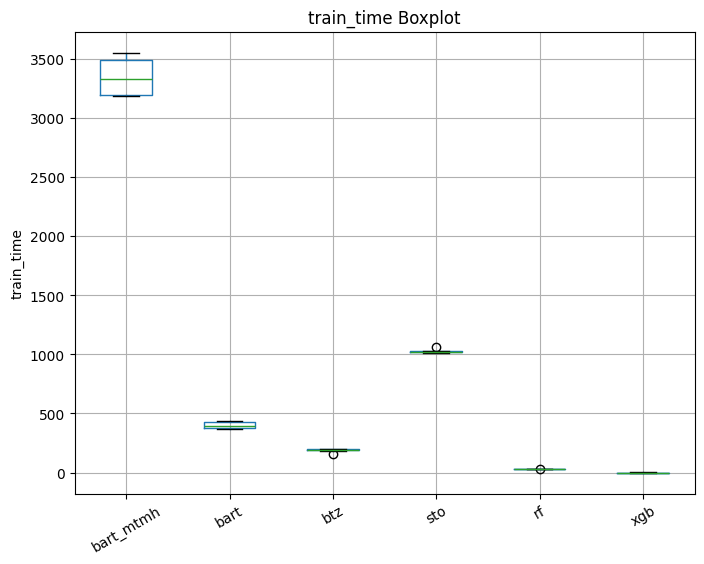

In [8]:
import matplotlib.pyplot as plt
import comparison
import pandas as pd

mse_results = comparison.bart_mse_comparison(X, y, n_runs=10, n_skip=1000, n_post=1000, n_trees=100, n_jobs=5)
for k, v in mse_results.items():
    mean_row = pd.DataFrame([v.mean()], index=["mean"])
    std_row = pd.DataFrame([v.std()], index=["std"])
    v_with_stats = pd.concat([v, mean_row, std_row])
    print(f"{k}:\n{v_with_stats}\n")
    
    plt.figure(figsize=(8, 6))
    v.boxplot()
    plt.title(f"{k} Boxplot")
    plt.ylabel(k)
    plt.xticks(rotation=30)
    plt.show()

In [9]:
for k, v in mse_results.items():
    csv_name = f"results/real5_BreastTumor_{k}.csv"
    v.to_csv(csv_name, index=False)

## Multi-tries

In [ ]:
from multi_tries import multi_tries_performance
import pandas as pd

csv_path = "results/real5_BreastTumor_tries.csv"
existing_df = None

if os.path.exists(csv_path):
    existing_df = pd.read_csv(csv_path)

df = multi_tries_performance(
    X, y,
    multi_tries_list=[1, 5, 10, 50],
    n_runs=5, n_chains=4,
    ndpost=1000, nskip=1000, n_trees=100, n_jobs=5
)

if existing_df is not None:
    df = pd.concat([existing_df, df], ignore_index=True)
    df = df.sort_values(by='multi_tries', ascending=True).reset_index(drop=True)

df.to_csv("results/real5_BreastTumor_tries.csv", index=False)

In [ ]:
print(df)

   multi_tries  Rhat_Sigma2  Rhat_RMSE   Test_MSE  Coverage    Train_Time
0            1     1.020415   1.693848  87.902579  0.936893    535.873454
1            5     1.009196   1.273469  87.648414  0.936152   1759.518606
2           10     1.006008   1.190470  87.580574  0.936646   3280.763591
3           50     1.005725   1.095668  87.506604  0.936187  15892.629620
